<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/nonconvex_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [339]:
import jax
from jax import lax
import jax.random as jrandom
import jax.numpy as jnp
import numpy as np
import time
import matplotlib.pyplot as plt
from functools import partial

# Utility Functions

In [340]:
'''
signed distance function of the domain
'''
#@jax.jit
def signDistance(p): # [cuts, samples, dimensions]
  '''
  # torus
  R = 2
  r = 1
  temp = jnp.sum(jnp.power(p,2), axis=2) + jnp.power(R,2) - jnp.power(r,2)
  final = jnp.power(temp,2) - 4 * jnp.power(R,2) * (jnp.power(p[:,:,0], 2) + jnp.power(p[:,:,1], 2))
  '''
  # unit sphere
  final = jnp.linalg.norm(p,ord=2,axis=2,keepdims=False) - 1
  return final

In [341]:
'''
Dirchlet boundary condition
'''
#@jax.jit
def boundaryCond(p, k):
  pointCharge = jnp.array([-1,-2,1.5])
  pointCharge = jnp.tile(pointCharge, (jnp.size(p,0), 1)) # [samples, dimensions]
  pDiff = jnp.linalg.norm(p - pointCharge, ord=2, axis=1, keepdims=False)
  final = jnp.exp(-k * pDiff) / (4 * jnp.pi * pDiff)
  return final

# Multi Root Finding

In [342]:
#@jax.jit
def bisection(p0, p1, rootSteps, dir):
  current = jnp.zeros((1, jnp.size(p0, 1)))

  def bisectionStep(i, current):
    next = current + jnp.power(0.5, i+1)
    dist1 = signDistance(p0 + dir * next[:,:,jnp.newaxis] * (p1 - p0))
    dist2 = signDistance(p0 + dir * current[:,:,jnp.newaxis] * (p1 - p0))
    return jnp.where(dist1 * dist2 > 0, next, current)

  current = lax.fori_loop(0, rootSteps, bisectionStep, current)

  return p0 + dir * current[:,:,jnp.newaxis] * (p1 - p0)

In [343]:
#@partial(jax.jit, static_argnames=['uni_cuts'])
def createGrid(p0, p1, uni_cuts):
  lb = jnp.zeros(len(p0))
  ub = jnp.ones(len(p1))
  t = jnp.linspace(lb, ub, uni_cuts, axis=0)
  return t  

In [344]:
#@partial(jax.jit, static_argnames=['ray'])
def rootIsolate(key, p0, p1, grid, ray=False):
  # find the roots
  v = signDistance(p0 + grid[:,:,jnp.newaxis] * (p1 - p0))
  v = jnp.where(v > 0, 1, -1)

  # get rid of the first half of the line
  if (ray):
    v = jnp.where(grid < 0.5, 10, v)

  # find the roots
  roots = v[:-1] + v[1:]

  # get rid of the root closest to 0.5
  if (not ray):
    # BUG: HAS TO DELETE SOMETHING EVEN IF THERES NOTHING TO DELETE. fixed?
    n_zeros = jnp.count_nonzero(roots == 0, axis=0)
    thing_tile = jnp.abs(grid[:-1] - 0.5) + 1
    n_zeros_tile = jnp.tile(n_zeros, (jnp.size(roots, 0), 1))
    closetomid = jnp.min((jnp.abs(roots) + 1) * thing_tile, axis=0)
    roots = jnp.where(jnp.logical_and((jnp.abs(roots) + 1) * thing_tile == closetomid, n_zeros_tile != 0), 100, roots)

  # check how many roots
  n_zeros = jnp.count_nonzero(roots == 0, axis=0)

  need_n_zeros = n_zeros

  # BUG: if there are still no roots, pick the middle of the line
  # THIS REQUIRES THE GRID TO CONTAIN 0.5 
  n_zeros_tile = jnp.tile(n_zeros, (jnp.size(roots, 0), 1))
  roots = jnp.where(jnp.logical_and(n_zeros_tile == 0, grid[:-1] == 0.5), 0, roots)
  n_zeros = jnp.count_nonzero(roots == 0, axis=0)

  # randomly pick a root
  minvals = jnp.zeros(jnp.size(grid, 1))
  random_indices = jrandom.randint(key, (1,jnp.size(grid, 1)), minval=minvals, maxval=n_zeros)

  # can speed this up by using a single for loop instead of: argsort + take_along_axis + custom_put_along_axis ?
  roots = jnp.where(roots == 0, 0, 1)
  all_root_indices = jnp.argsort(roots, axis=0)
  root_indices = jnp.take_along_axis(all_root_indices, random_indices, axis=0)

  lb = jnp.take_along_axis(grid, root_indices, axis=0)
  ub = jnp.take_along_axis(grid, root_indices+1, axis=0)
  
  # return the roots interval
  return lb, ub, n_zeros, need_n_zeros

In [345]:
#@partial(jax.jit, static_argnames=['uni_cuts', 'quad_cuts', 'ray'])
def multiRootSearch(key, p0, p1, uni_cuts, rootSteps=10, ray=False):
  p1 = p0 + p1
  p0 = 2*p0 - p1
  
  # adjust for errors with random?
  keys = jrandom.split(key, 2)

  grid = createGrid(p0, p1, uni_cuts)
  t1, t2, n_roots, need_n_zeros = rootIsolate(keys[0], p0, p1, grid, ray=ray)

  root = bisection(p0 + t1[:,:,jnp.newaxis] * (p1 - p0),
                   p0 + t2[:,:,jnp.newaxis] * (p1 - p0),
                   rootSteps, dir=1)
  
  bound_sign = jnp.sign(signDistance(p0 + t1[:,:,jnp.newaxis] * (p1 - p0)))

  if (not ray):
    # fix sign for reccurent roots
    poop = jnp.where(need_n_zeros == 0, 0, 1)
    temp_poop = jrandom.choice(keys[1], jnp.array([-1, 1]), poop.shape)
    bound_sign = bound_sign * poop + (1 - poop) * temp_poop

  dir_sign = jnp.where(t1 < 0.5, 1, -1)
  actual_sign = bound_sign * dir_sign

  return root[0], actual_sign, n_roots

# Walk on Boundary Functions

In [346]:
'''
run the wob and calculate the estimator
'''
#@jax.jit
def wob(keys, p0, p1, t, rootSteps, k):
  running_est = jnp.zeros((len(p0))) # [samples]
  
  p_next, sign, n_roots = multiRootSearch(keys[0], p0, p1[0], uni_cuts=21, rootSteps=rootSteps, ray=True)
  p_diff = jnp.linalg.norm(p0 - p_next, ord=2, axis=1)
  q_next = 2 * n_roots * sign[0] * jnp.exp(-k * p_diff) * (1 + k * p_diff)
  p_before = p_next

  #plt.scatter(p_next[:,0], p_next[:,1])

  for i in range(1, len(p1)):
    running_est += boundaryCond(p_next, k) * q_next
    
    p_next, sign, n_roots = multiRootSearch(keys[i], p_next, p1[i], uni_cuts=21, rootSteps=rootSteps)
    
    p_diff = jnp.linalg.norm(p_before - p_next, ord=2, axis=1)
    q_next = - n_roots * sign[0] * q_next * jnp.exp(-k * p_diff) * (1 + k * p_diff)
    p_before = p_next

  #plt.scatter(p_next[:,0], p_next[:,1])

  running_est += 0.5 * boundaryCond(p_next, k) * q_next
  return running_est

In [347]:
'''
setup the wob
'''
def computeSoln(key, p, t=5, rootSteps=10, samples=1000, diameter=1, k=0):
  p0 = jnp.tile(p, (samples,1)) # [samples, dimensions]

  keys = jrandom.split(key, t+1)
  # generate random directions in n-dimensions
  p1 = jrandom.normal(keys[0], shape=(t, samples, jnp.size(p0, 1)))
  normalize = jnp.linalg.norm(p1, ord=2, axis=2, keepdims=True)
  p1 = diameter * jnp.divide(p1, normalize) # [jumps, dimensions, samples]
  
  ans = wob(keys[1:], p0, p1, t, rootSteps, k)

  return jnp.mean(ans, axis=0, keepdims=True), jnp.std(ans, axis=0, keepdims=True)

# Testing

In [370]:
%%time
'''
testing code
'''
key = jrandom.PRNGKey(int(time.time()))
x = jnp.array([0.5, 0.5, 0])

y, sd = computeSoln(key, x, t=2, rootSteps=20, samples=2, diameter=3, k=0)
print('solution:', y)
print('exact:', boundaryCond(jnp.array([x]), k=0))

solution: [0.02264306]
exact: [0.0242709]
CPU times: user 221 ms, sys: 1.93 ms, total: 223 ms
Wall time: 221 ms


[0.02600668]
[0.02575205]
[0.0255838]
[0.02490015]
[0.02502825]
[0.02509579]
[0.02411777]
[0.02540216]
[0.02556402]
[0.02529901]
[0.02544104]
[0.02549307]
[0.02505563]
[0.02599171]
[0.02566902]
[0.02496699]
[0.02522829]
[0.02530536]
[0.02526591]
[0.02507378]
[0.02608046]


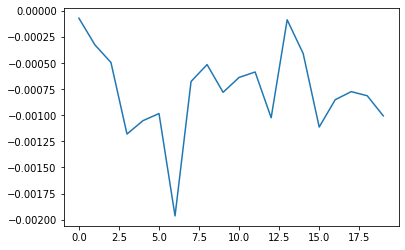

In [366]:
'''
key = jrandom.PRNGKey(int(time.time()))
keys = jrandom.split(key, 20)
y_points = []
for i in range(20):
  y, sd = computeSoln(keys[i], x, t=5, rootSteps=20, samples=10_000, diameter=3, k=0)
  y_points.append(y - boundaryCond(jnp.array([x]), k=0))

plt.plot(y_points)
'''